# Requirements

In [1]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


# Libraries

In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# System Libraries
import os
import random
import os.path
from pathlib import Path

# Visualization Libraries
import cv2
import seaborn as sns
import matplotlib.cm as cm
from PIL import Image, ImageChops, ImageEnhance

# Metrics
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra
from termcolor import colored
#from google.colab import drive
import zipfile

# Data

## Global Variable

In [3]:
PATH = '/kaggle/input/deepfakesss/similar'
PATH_styletransfer = '/kaggle/input/deepfakesss/similar/style_transfer'
PATH_inpainting = '/kaggle/input/deepfakesss/similar/inpainting'
images = []
class_list = []
labels_class = ['Original', 'AI Generated']
labels_class

['Original', 'AI Generated']

### Load Inpainting Image

In [4]:
class_0_count = 0
class_1_count = 0
max_images_per_class = 4000

for i, class_name in enumerate(os.listdir(PATH_inpainting)):
    for j, file in enumerate(os.listdir(os.path.join(PATH_inpainting, class_name))):
        if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
            break  # Stop if both classes have reached the limit
        
        if file == 'original.png' or file == "inpainting.png":
            image = load_img(os.path.join(PATH_inpainting, class_name, file))
            image = img_to_array(image) / 255.0

            # Resize image
            image = tf.image.resize(image, (224, 224))
            images.append(image)

            if file == 'original.png' and class_0_count < max_images_per_class:
                class_list.append(0)
                class_0_count += 1
            elif file == 'inpainting.png' and class_1_count < max_images_per_class:
                class_list.append(1)
                class_1_count += 1

    # Break the outer loop if both classes have reached the limit
    if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
        break

### Load Style Transfer Image

In [5]:
print(len(images))

8000


## Data Distribution

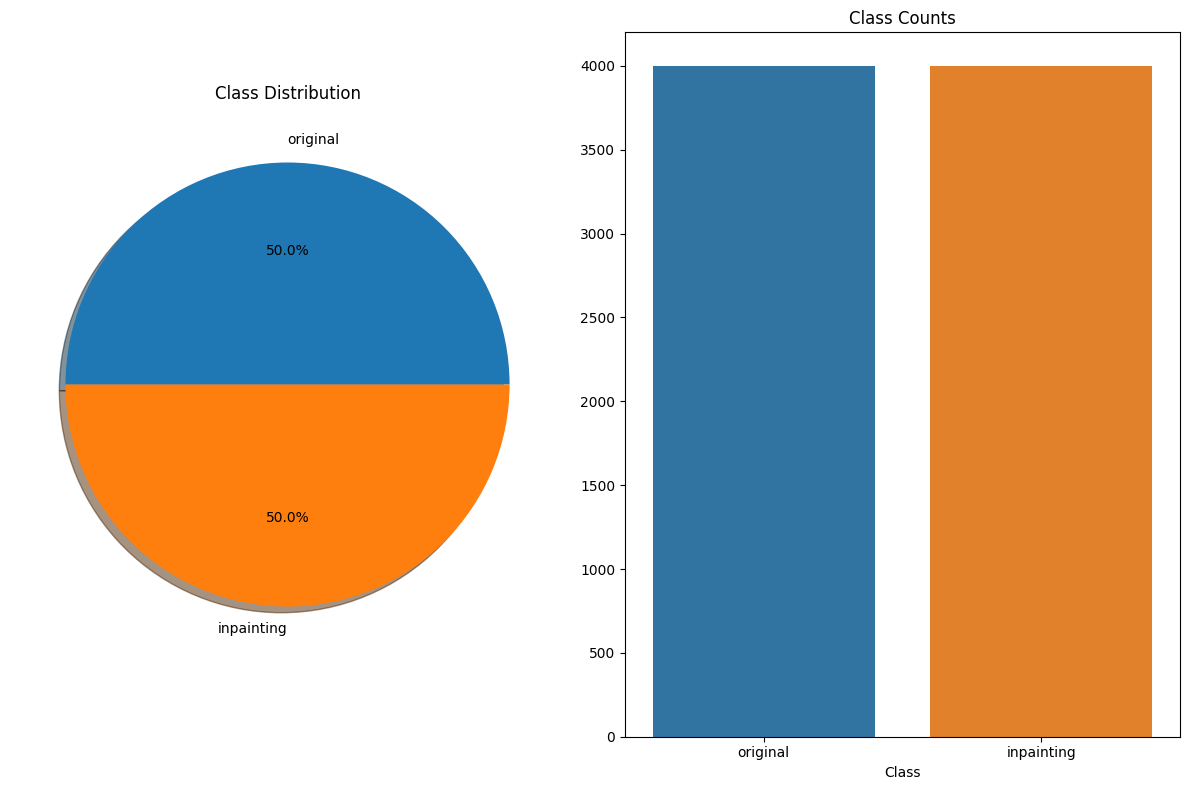

In [6]:
from collections import Counter

class_labels = {0: 'original', 1: 'inpainting'}
mapped_class_list = [class_labels[c] for c in class_list] 
class_counts = Counter(mapped_class_list)
class_series = pd.Series(class_counts)


fig, ax = plt.subplots(1, 2, figsize=(12, 8))
class_series.plot(kind='pie', ax=ax[0], autopct='%1.1f%%', shadow=True)
ax[0].set_title('Class Distribution')
ax[0].set_ylabel('') 
sns.countplot(x=mapped_class_list, ax=ax[1], order=['original', 'inpainting'])
ax[1].set_title('Class Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('')  

plt.tight_layout()
plt.show()

## Augmentation

### Function

In [7]:
def augment_image(image):
    aug_image = tf.image.random_flip_left_right(image)
    aug_image = tf.image.random_flip_up_down(aug_image)
    aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
    aug_image = tf.image.random_contrast(aug_image, lower=0.8, upper=1.2)
    return aug_image

## Random Image to Plot

In [8]:
def augment_flip_horizontal(image):
    return tf.image.flip_left_right(image)

def augment_flip_vertical(image):
    return tf.image.flip_up_down(image)

def augment_brightness(image, delta=0.2):
    return tf.image.adjust_brightness(image, delta)

def augment_contrast(image, lower=0.8, upper=1.2):
    return tf.image.random_contrast(image, lower=lower, upper=upper)

### Original Image

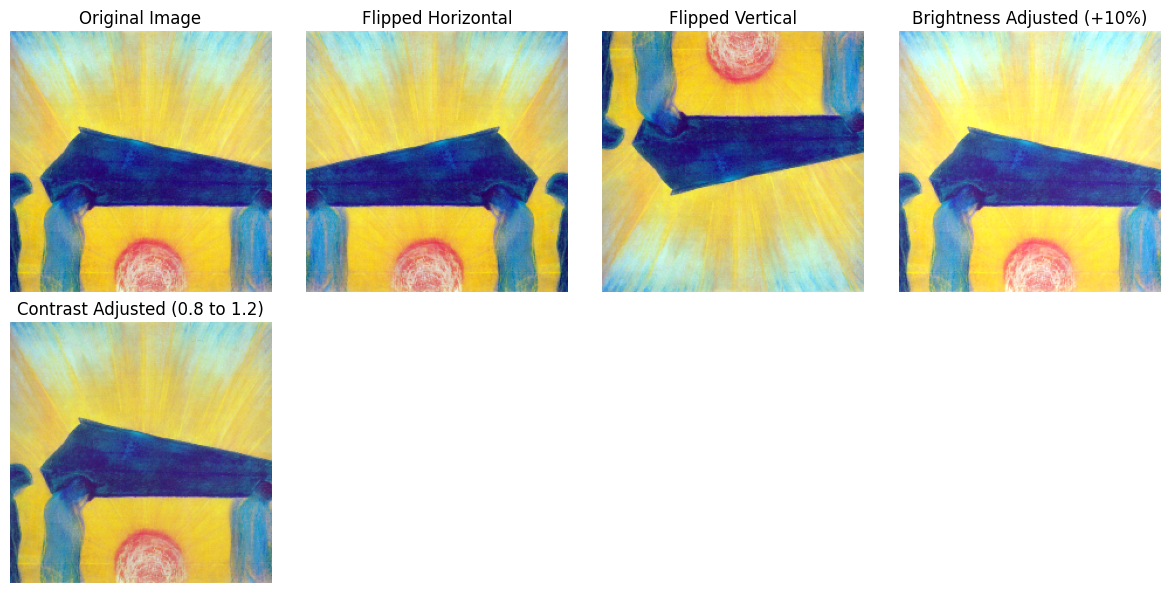

In [9]:
while True:
    class_name = random.choice(os.listdir(PATH_inpainting))
    file = random.choice(os.listdir(os.path.join(PATH_inpainting, class_name)))
    if file == "original.png":
        image_path = os.path.join(PATH_inpainting, class_name, file)
        break  # Exit the loop when "original.png" is found

image = load_img(image_path)
image = img_to_array(image)
image = image/255.0
image = tf.image.resize(image, (224, 224))

augmented_images = [
    augment_flip_horizontal(image),
    augment_flip_vertical(image),
    augment_brightness(image, delta=0.1),  # Mengurangi kecerahan sebesar 10%
    augment_contrast(image, lower=0.8, upper=1.2),  # Kontras pada rentang yang ditentukan
]

titles = [
    "Flipped Horizontal",
    "Flipped Vertical",
    "Brightness Adjusted (+10%)",
    "Contrast Adjusted (0.8 to 1.2)"
]

plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (aug_img, title) in enumerate(zip(augmented_images, titles), start=2):
    plt.subplot(2, 4, i)
    plt.imshow(tf.squeeze(aug_img), cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

### AI - Generated Image

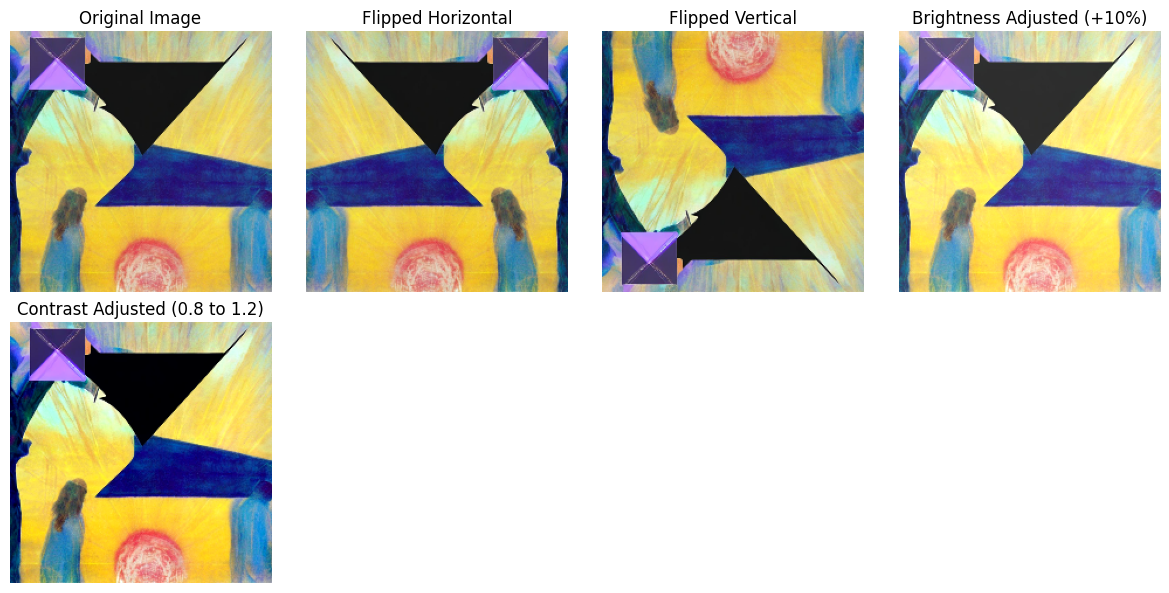

In [10]:
image_path = os.path.join(PATH_inpainting, class_name, 'inpainting.png')

image = load_img(image_path)
image = img_to_array(image)
image = image/255.0
image = tf.image.resize(image, (224, 224))

augmented_images = [
    augment_flip_horizontal(image),
    augment_flip_vertical(image),
    augment_brightness(image, delta=0.1),  # Mengurangi kecerahan sebesar 10%
    augment_contrast(image, lower=0.8, upper=1.2),  # Kontras pada rentang yang ditentukan
]

titles = [
    "Flipped Horizontal",
    "Flipped Vertical",
    "Brightness Adjusted (+10%)",
    "Contrast Adjusted (0.8 to 1.2)"
]

plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (aug_img, title) in enumerate(zip(augmented_images, titles), start=2):
    plt.subplot(2, 4, i)
    plt.imshow(tf.squeeze(aug_img), cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Encoding Data & Image as array

In [11]:
y = np.array(class_list)
images = np.asarray(images)

# Data Processing

## Splitting Data

In [12]:
total_samples = len(images)

X_train, X_temp, y_train, y_temp = train_test_split(images, y, test_size=0.2, random_state=0, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

# Size
print(f"Train set size: {len(X_train)} ({len(X_train) / total_samples:.2%})")
print(f"Validation set size: {len(X_val)} ({len(X_val) / total_samples:.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test) / total_samples:.2%})")

Train set size: 6400 (80.00%)
Validation set size: 800 (10.00%)
Test set size: 800 (10.00%)


## Augmenting Training Dataset

In [13]:
# augmented_images = []
# augmented_labels = []

# for image, label in zip(X_train, y_train):
#     augmented_images.append(image)  
#     augmented_labels.append(label)
#     for _ in range(3): 
#         augmented_image = augment_image(image)
#         augmented_images.append(augmented_image)
#         augmented_labels.append(label)

# # Convert augmented lists to numpy arrays
# X_train = np.array(augmented_images)
# y_train = np.array(augmented_labels)

# Model

## Model Architecture

In [14]:
base_model = ResNet50V2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Global Average Pooling layer

# Add a Dense layer with L2 regularization
model.add(layers.Dense(512, activation='relu'))

# Output layer (binary classification, hence the sigmoid activation)
model.add(layers.Dense(1, activation='sigmoid'))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Callbacks

In [15]:
# Model Checkpoint
checkpoint_cb = ModelCheckpoint('MyModel.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')

# Early Stopping
earlystop_cb = EarlyStopping(patience=20, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## Compile

In [16]:
model.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Training

In [17]:
history = model.fit(
    X_train,
    y_train,
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr],
    batch_size = 32
)

Epoch 1/50


I0000 00:00:1732991353.496845     112 service.cc:145] XLA service 0x7be6fd261640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732991353.496909     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/200 ━━━━━━━━━━━━━━━━━━━━ 2:27:53 45s/step - accuracy: 0.4375 - loss: 0.7344

I0000 00:00:1732991375.924711     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 170ms/step - accuracy: 0.5192 - loss: 0.7208 - val_accuracy: 0.5213 - val_loss: 10.5645 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.6116 - loss: 0.6674 - val_accuracy: 0.4588 - val_loss: 8.3577 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.6211 - loss: 0.6638 - val_accuracy: 0.5013 - val_loss: 1.7673 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.6667 - loss: 0.6231 - val_accuracy: 0.5987 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.6775 - loss: 0.6168 - val_accuracy: 0.5888 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.6715 - loss: 0.6118 - val_accuracy: 0.4863 - val_loss: 30.4820 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.6493 - los

In [18]:
model.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7367 - loss: 0.5315


[0.5250900387763977, 0.7300000190734863]

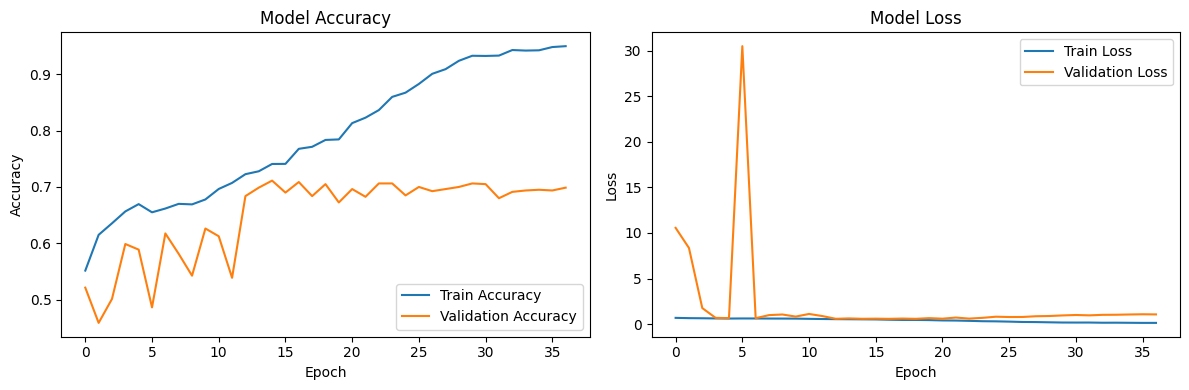

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


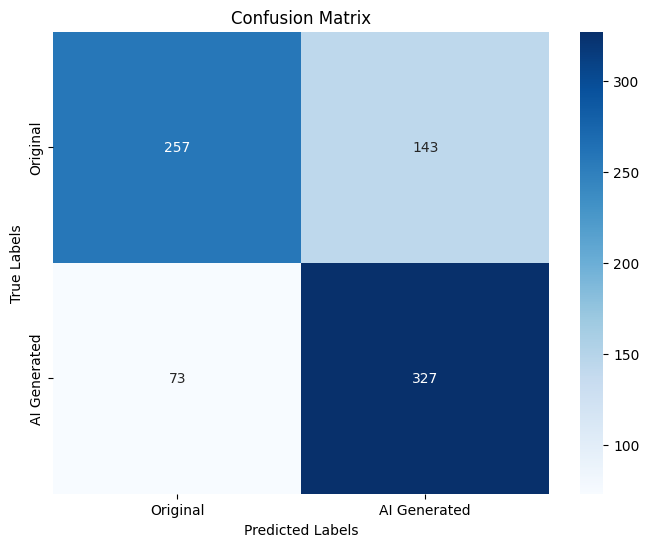

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions from the model
# Assuming `model` is your trained model and `X_test` is the test set
predicted_probabilities = model.predict(X_test)  # Predictions for sigmoid output

# Convert probabilities to binary class predictions
threshold = 0.5
predicted_labels = (predicted_probabilities > threshold).astype(int).flatten()

# Getting all the true labels for the test set
true_labels = y_test.flatten()  # Ensure y_test is flattened if it’s not already

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class labels (binary classification: 0 and 1)
class_names = ['Original', 'AI Generated']  # Replace with your actual class names if needed

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class labels mapping
class_labels = {0: "Original", 1: "AI Generated"}

# Predict probabilities using the model
predictions = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1) for binary classification
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Select random indices for visualization
random_indices = np.random.choice(len(X_test), size=25, replace=False)

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Get random image, true label, and predicted label
    img = X_test[random_indices[i]]  # Assuming X_test contains image arrays
    true_label = y_test[random_indices[i]]
    pred_label = predicted_labels[random_indices[i]]

    # Display the image
    if isinstance(img, str):  # If X_test contains file paths
        img = plt.imread(img)
    ax.imshow(img)

    # Determine title color based on prediction accuracy
    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    # Set the title with true and predicted class names
    ax.set_title(f"True: {class_labels[true_label]}\nPredicted: {class_labels[pred_label]}", color=color)

plt.tight_layout()
plt.show()
